# Convolutional Neural Network - Pattern Recognition in Stock Markets

In [90]:
import datetime
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import csv
import warnings
import sys
import importlib
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical

N = 20

In [91]:
%matplotlib inline

In [92]:
#hide all warnings
#warnings.filterwarnings('ignore')

#show all warnings just once
warnings.filterwarnings(action='once')

In [93]:
from helpers import delete_nans, get_returns, plot_example_returns, tickers, get_data_subsets#, data_loader

# Download Data

In [94]:
begin = "2007-01-01"
finish = "2017-01-01"

#data_loader(begin, finish, 'returns.csv')

In [95]:
returns = get_returns('returns.csv', N)

Number of columns with only NaNs: 0
Number of lines with only NaNs: 0
Number of NaNs: 0
shape Dataframe: (2518, 20)


## Helper Functions

MMM       ABT  ABBV      ABMD       ACN      ATVI      ADBE  \
Date                                                                           
2007-01-03  0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
2007-01-04 -0.003961  0.018991   0.0  0.021352  0.022540  0.008158  0.022545   
2007-01-05 -0.006799  0.000000   0.0 -0.014634 -0.013979 -0.005780 -0.004900   
2007-01-08  0.002195  0.003607   0.0 -0.002122  0.014449 -0.000581 -0.004185   
2007-01-09  0.001160  0.008786   0.0 -0.010631 -0.002419 -0.000582 -0.020272   

                 AMD       AAP       AES       AMG       AFL         A  \
Date                                                                     
2007-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2007-01-04  0.013832  0.006464  0.000456 -0.010861 -0.011027  0.003207   
2007-01-05 -0.004043 -0.022061 -0.028702 -0.008021  0.001312 -0.009299   
2007-01-08 -0.012177  0.003427 -0.014071  0.013187  0.000655 -0.003520   
2007-01-09  0.009245  0.008537 -0.040914  0.009690  0.003709  0.001178   

                 APD      AKAM       ALK       ALB       ARE      ALXN  \
Date                                                                     
2007-01-03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2007-01-04 -0.021972  0.023622  0.019508 -0.004584 -0.001686  0.002955   
2007-01-05 -0.013934 -0.002064 -0.036116 -0.017446 -0.019664 -0.006629   
2007-01-08 -0.001298 -0.003384  0.021092 -0.005114 -0.009523 -0.027435   
2007-01-09 -0.002166 -0.006414  0.008263  0.005854  0.024956 -0.007624   

                ALGN  
Date                  
2007-01-03  0.000000  
2007-01-04  0.018727  
2007-01-05  0.002941  
2007-01-08  0.002933  
2007-01-09  0.001462

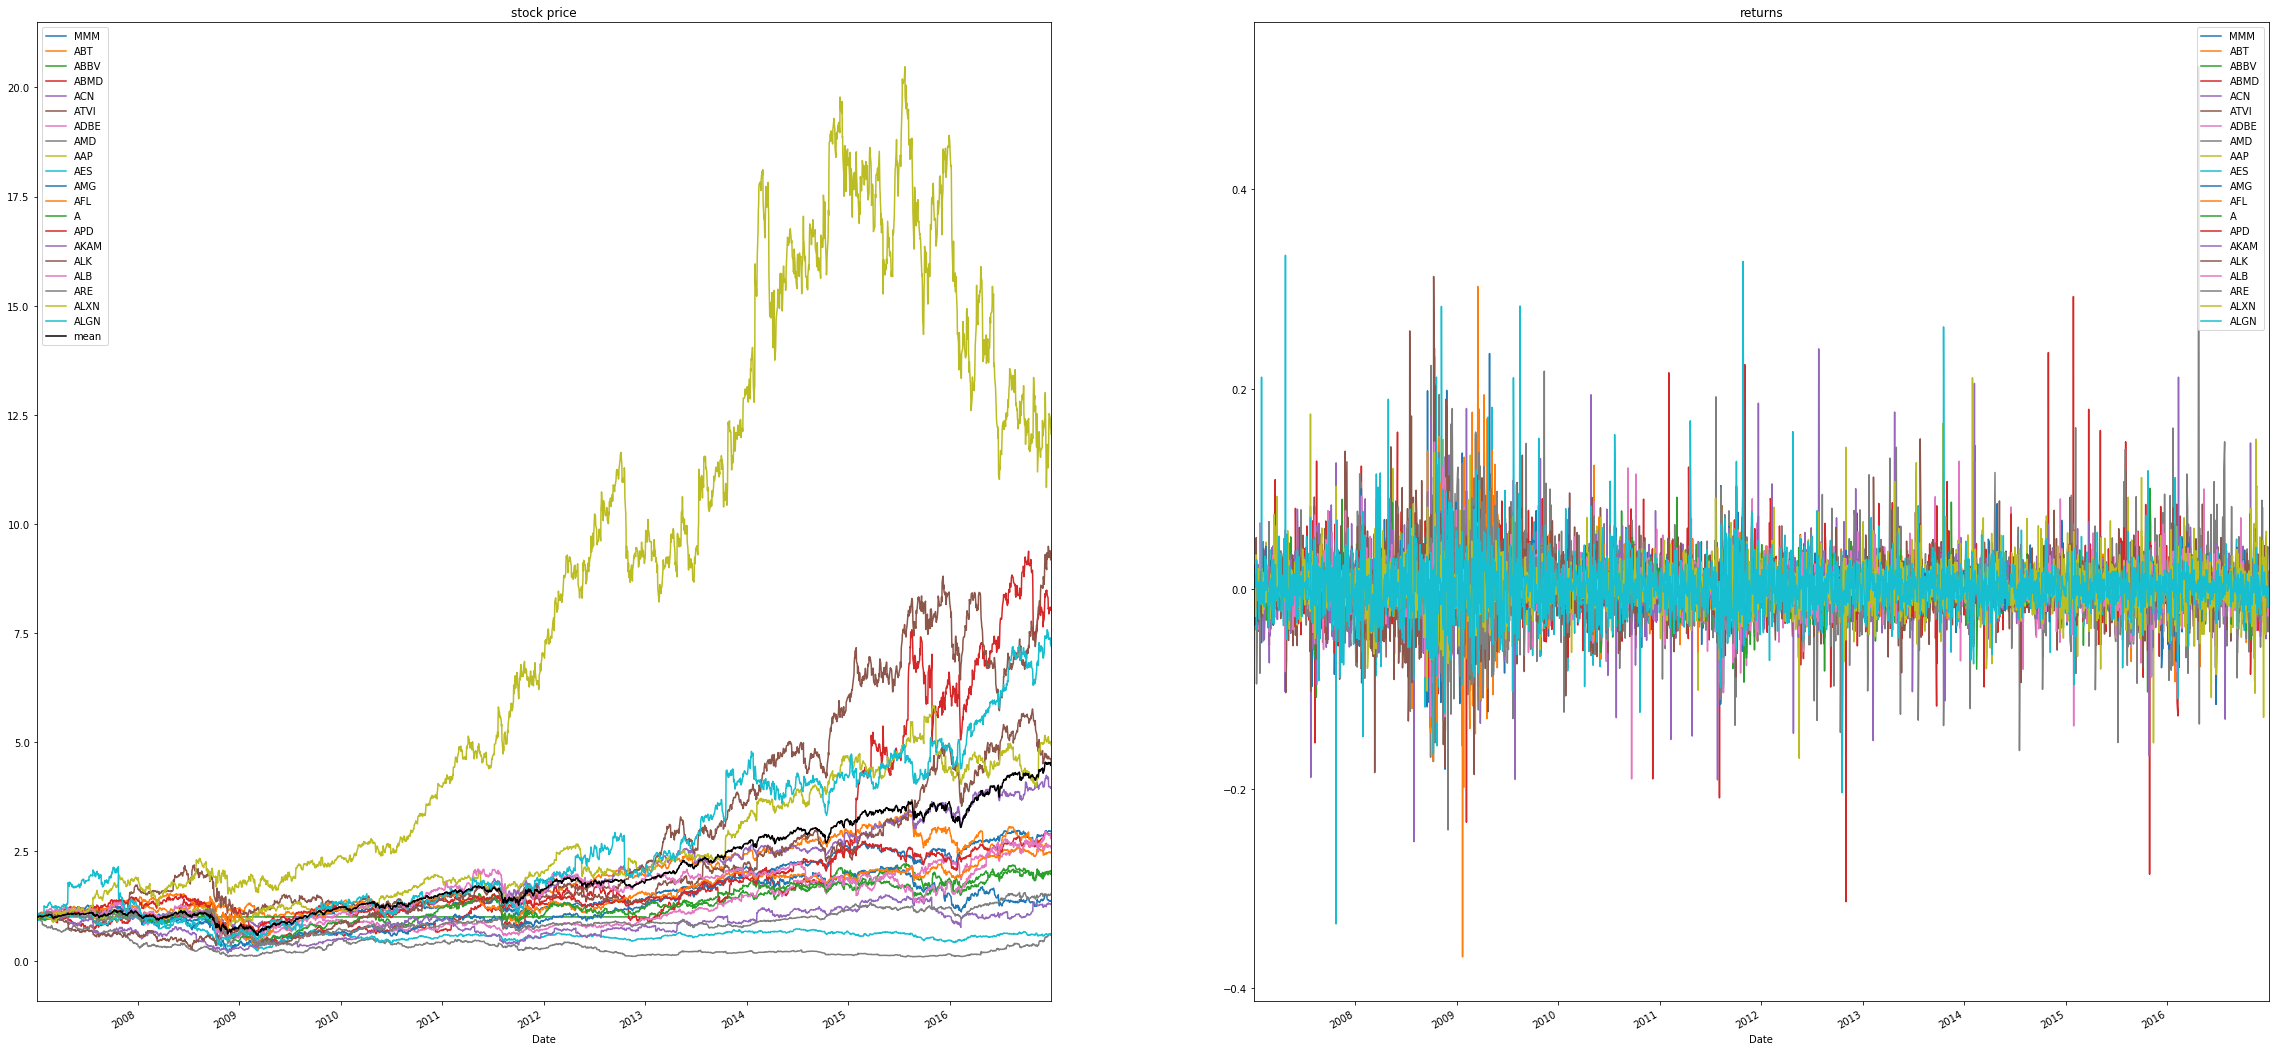

In [96]:
delete_nans('returns.csv', 'returns.csv')
plot_example_returns('returns.csv', N)

## Calculations 

In [97]:
def cnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1, 100, 50 
    """
    verbose: 0-kein output, 1-ladebalken, 2-epochenzahlen printen
    batch_size: Nicht definieren (https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc)
    epochs: Anzahl Iterationen durch das Trainingsset
    """
    
    #init
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=inp_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    #Conv1D => 1D Convolution (Schaut nach Mustern)
    #mit filters = Anzahl Weight Functions, kernel_size = Anzahl simultan betrachteter Felder, 
    #relu = 0 für value<0 sonst linear
    
    model.add(layers.Dropout(0.5))
    #Dropout sets randomly chosen values to 0 to prevent overfitting
    
    model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
    model.add(layers.Flatten())
    #Flatten reduziert dimensionen eines arrays auf niedrigst mögliche Dimension (1xdim) (überschreibt Nullen))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(N, activation='linear'))
    #Klassisches NN hinter Convolutional Layer geschaltet, lernt also im Feature Raum, durch Convolutional Net vorgebenen
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae']) 
    #mean_squared_error (mse) and mean_absolute_error (mae)
    
    #fit network
    history_cnn = model.fit(x_train,y_train, epochs=epochs, #batch_size=batch_size, 
              verbose=verbose)
    #evaluate model
    
    #Print error values for classification of goodness
    mse,mse2,mae = model.evaluate(x_test,y_test, batch_size=batch_size, verbose=verbose)
    print(mse)
    print(mse2)
    print(mae)
    return model,history_cnn
    

In [98]:
def rnn(x_train, y_train, x_test, y_test, inp_shape):
    verbose, epochs, batch_size = 1, 100, 50 
    

    hidden_size = int(2/3 * (N*100))
    

    model = models.Sequential()

  
    
    model.add(layers.LSTM(hidden_size, activation='relu', kernel_initializer='he_normal', input_shape=inp_shape))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='relu',kernel_initializer='he_normal'))
    model.add(layers.Dense(N, activation='linear',kernel_initializer='he_normal'))
    # model.add(layers.Dense(1))
        
#     model.add(layers.MaxPooling1D(pool_size=2))
    #MaxPooling halbiert array Größe und nimmt größte Werte der Feature-Gewichtungen 
    
#     model.add(layers.Flatten())
    
    

    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
    # fitting the model
    history_rnn = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(x_test, y_test))
    # evaluate the model
    mse,mse2,mae = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=verbose)
    
    print(mse)
    print(mse2)
    print(mae)
    
    return model,history_rnn

In [ ]:
def main(input_df, dur, limit):
    """
    input_df    die Input Matrix (duh)
    dur         Zeitfenster
    limit       Grenze für Train Test Split
    """
    
    N = input_df.shape[1]
    D = input_df.shape[0]
    inp_shape=(dur,N)
    train = input_df.iloc[:limit,:]
    test = input_df.iloc[limit-dur:,:]
    x_train,y_train = get_data_subsets(train, dur) 
    x_test,y_test = get_data_subsets(test, dur)
    
    """für Dimensions-tests"""
    print('x-train shape: ' + str(x_train.shape))
    print('y-train shape: ' + str(y_train.shape))
    print('x-test shape: ' + str(x_test.shape))
    print('y-test shape: ' + str(y_test.shape))
    print('test shape: ' + str(test.shape))
 
    print('CNN Epochs')
    model_cnn,history_cnn = cnn(x_train, y_train, x_test, y_test, inp_shape)
    
    print('RNN Epochs')      
    model_rnn,history_rnn = rnn(x_train, y_train, x_test, y_test, inp_shape)
    
    return model_rnn,model_cnn,x_test,y_test,history_rnn,history_cnn

model_rnn,model_cnn,x_test,y_test,history_rnn,history_cnn = main(returns, 100, 2000)




### Tests 

Function to check wether stock value changes were recognised to increase/decrease correctly

In [ ]:
def directional_goodness(model,x_new,y_new):
    """
    directional goodnes gives the factor of correctly predicted signs of first order derivative of returns to false ones
    oder auch: 
    gibt die Anzahl der Beobachtungen an, deren Vorhersage das richtige Vorzeichen hatte (Kurs steigt, Kurs fällt)
    """
    y_pred = model.predict(x_new)
    count = 0
    #print(y_new.shape)
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            p= y_pred[i,j] > 0
            n = y_new[i,j] > 0
            if n==p:
                count +=1
    print('percentage of correctly predicted directions of returns: ' + str(count/len(y_pred)/len(y_pred[0])))

In [ ]:
directional_goodness(model_cnn,x_test,y_test)

In [ ]:
directional_goodness(model_rnn,x_test,y_test)

Function to check internal goodness - predicted values vs actual measured values used for training

In [17]:
def internal_goodness(model, x_new, y_new):
    print('compare true to predicted values of internal validation on learned dataset: ')
    y_pred = model.predict(x_new)
    #model.predict nimmt x-werte und gibt die predicteten y-werte zurück
    plt.scatter(y_new, y_pred)

compare true to predicted values of internal validation on learned dataset: 


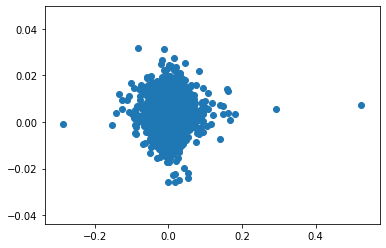

In [18]:
internal_goodness(model_cnn,x_test,y_test)

compare true to predicted values of internal validation on learned dataset: 


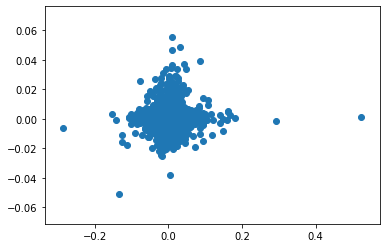

In [19]:
internal_goodness(model_rnn,x_test,y_test)

Function to check external goodness - predicted values for future data vs actual future data

In [20]:
def external_goodness(model, x_new, y_new):
    print('compare true to predicted values of external validation set: ')
    y_pred = model.predict(x_new)
    color =  ["r", "b", "g"]
    for i in range(3):
        plt.plot(y_new[i],c=color[i], label = 'true')
        plt.plot(y_pred[i], c=color[i], linestyle='--', label = 'pred')
    plt.legend()

compare true to predicted values of external validation set: 


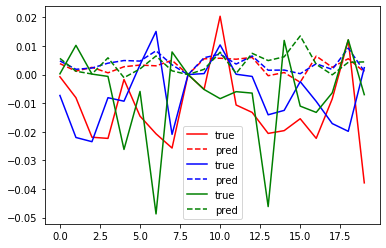

In [21]:
external_goodness(model_cnn,x_test,y_test)

compare true to predicted values of external validation set: 


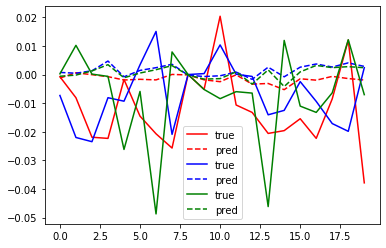

In [22]:
external_goodness(model_rnn,x_test,y_test)

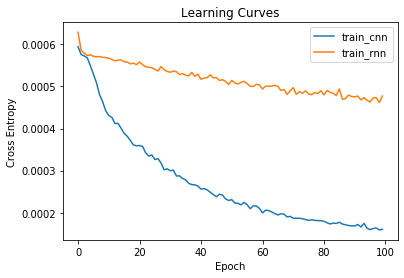

In [38]:
###### cross entropy loss CNN
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history_cnn.history['loss'], label='train_cnn')
plt.plot(history_rnn.history['loss'], label='train_rnn')
# plt.plot(history_rnn.history['mean_absolute_error'], label='mse')
plt.legend()
plt.show()

In [25]:
print(history_cnn.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error'])


In [27]:
print(history_rnn.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])
